### Documentation here https://dev.elsevier.com/documentation/ArticleRetrievalAPI.wadl
https://api.elsevier.com/content/article/doi/{doi}

# Save the cleaned DataFrame to a new CSV file
cleaned_file_path = 'elsevier_search_results_cleaned.csv'
df_cleaned.to_csv(cleaned_file_path, index=False)

print(f"Cleaned data saved to {cleaned_file_path}")


df = pd.read_csv('elsevier_search_results_cleaned.csv')

In [3]:
import pandas as pd
import requests
import os
import xmltodict
import json
from _credentials import keys
import csv
import json

In [9]:
# !pip install lxml requests pandas tqdm --quiet

import os, re, json, time, unicodedata
from typing import Optional, List, Tuple
import pandas as pd
import requests
from lxml import etree as ET
from tqdm import tqdm

# =========================
# Credentials
# =========================
from _credentials import keys   # you must have _credentials.py with your dict
API_KEY = keys["els-apikey"]
INST_TOKEN = keys.get("els-insttoken")  # optional

# =========================
# CONFIG
# =========================
CSV_PATH = "csv_output/300_manually_filtered/_verification-list.csv"
DOI_COLUMN_CANDIDATES = ["DOI", "doi", "Doi"]

RAW_DIR = "papers_raw"
EXTRACT_DIR = "papers_extracted"
NO_MR_CSV = os.path.join(EXTRACT_DIR, "no_methods_results.csv")

# Bridge to classifier-ready JSONs (optional)
MAKE_FTRR = True
FTRR_DIR = "papers_ftrr"
BRIDGE_FAIL_CSV = os.path.join(FTRR_DIR, "bridge_failures.csv")

ACCEPT_FORMAT = "xml"  # fetch full text in XML

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(EXTRACT_DIR, exist_ok=True)
if MAKE_FTRR:
    os.makedirs(FTRR_DIR, exist_ok=True)

# =========================
# Patterns (Methods/Results + exclusions)
# =========================
def normalize(s: str) -> str:
    if s is None:
        return ""
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = re.sub(r"[^a-z0-9\s&\-]", " ", s.lower())
    s = re.sub(r"\s+", " ", s).strip()
    return s

METHODS_PATTERNS = [
    r"\bmethods?\b", r"\bmethodolog(y|ies)\b",
    r"\bmaterials?\s+and\s+methods?\b",
    r"\bexperimental(\s+(setup|procedure|procedures|design))?\b",
    r"\bapproach\b", r"\bdata\s*collection\b",
    r"\bdata\s*(and|&)\s*methods\b",
    r"\bstudy\s*design\b", r"\bprotocol\b",
    r"\bimplementation\b", r"\bprocedures?\b",
    r"\b(framework|conceptual\s+framework|system\s+framework|methodological\s+framework)\b",
    r"\b(system|model|architecture)\s+(overview|design|description)\b",
]

RESULTS_PATTERNS = [
    r"\bresults?\b", r"\bresults?\s*(and|&)\s*analysis\b",
    r"\bfindings?\b", r"\bevaluation\b",
    r"\bempirical\s+results?\b", r"\boutcomes?\b",
    r"\bperformance\b", r"\bexperiments?\b",
    r"\bresults?\s*(and|&)\s*(experiments?|evaluation)\b",
]

MIXED_RESULTS_DISCUSSION = [
    r"\bresults?\s*(and|&)\s*discussion\b",
    r"\bdiscussion\s*(and|&)\s*results?\b",
]

EXCLUDE_PATTERNS = [
    r"\babstract\b", r"\bintroduction\b", r"\bbackground\b",
    r"\b(preliminaries|foundations?)\b",
    r"\bliterature\s+review\b", r"\brelated\s+work\b",
    r"\bstate\s+of\s+the\s+art\b", r"\btheor(etical|y)\b",
    r"\bconclusion(s)?\b", r"\blimitation(s)?\b",
    r"\bthreats?\s+to\s+validit(y|ies)\b",
    r"\bfuture\s+work\b", r"\bdiscussion(s)?\b",
    r"\bappendix\b", r"\bsupplement(ary|al)?\b",
    r"\backnowledg?e?ments?\b", r"\bfunding\b",
    r"\bethics\b", r"\bcompeting\s+interests?\b",
    r"\bauthor\s+contributions?\b",
    r"\bdata\s+availability\b", r"\breferences?\b",
    r"\bbibliograph(y|ies)\b",
]

HARD_STOP_PATTERNS = [
    r"\breferences?\b", r"\bbibliograph(y|ies)\b",
    r"\bappendix\b", r"\bsupplement(ary|al)?\b"
]

def label_for_title(title_norm: str, elimination_fallback=True) -> Optional[str]:
    if any(re.search(p, title_norm) for p in EXCLUDE_PATTERNS):
        return None
    if any(re.search(p, title_norm) for p in MIXED_RESULTS_DISCUSSION):
        return "mixed_results_discussion"
    if any(re.search(p, title_norm) for p in METHODS_PATTERNS):
        return "methods"
    if any(re.search(p, title_norm) for p in RESULTS_PATTERNS):
        return "results"
    if elimination_fallback and title_norm:
        return "unsure_core"
    return None

def should_hard_stop(title_norm: str) -> bool:
    return any(re.search(p, title_norm) for p in HARD_STOP_PATTERNS)

# Namespaces
NS = {
    "ce": "http://www.elsevier.com/xml/common/dtd",
    "ja": "http://www.elsevier.com/xml/ja/dtd",
    "sa": "http://www.elsevier.com/xml/sa/dtd",
    "xocs": "http://www.elsevier.com/xml/xocs/dtd",
    "dc": "http://purl.org/dc/elements/1.1/",
}

def text_of(elem) -> str:
    if elem is None:
        return ""
    return re.sub(r"\s+", " ", " ".join(elem.itertext())).strip()

def section_title(sec) -> str:
    st = sec.find("ce:section-title", NS)
    if st is not None:
        return text_of(st)
    for ch in sec:
        if isinstance(ch.tag, str) and ch.tag.endswith("section-title"):
            return text_of(ch)
    return ""

def walk_sections(root):
    def recurse(sec, path):
        t = section_title(sec)
        path2 = path + [t] if t else path
        yield (path2, t, sec)
        for sub in sec.findall("ce:section", NS):
            yield from recurse(sub, path2)
    top = root.findall(".//ce:sections/ce:section", NS)
    if not top: top = root.findall(".//ce:section", NS)
    for s in top:
        p = s.getparent()
        if p is None or (isinstance(p.tag, str) and not p.tag.endswith("section")):
            yield from recurse(s, [])

def extract_from_structured_abstract(root):
    out = {"methods": [], "results": [], "mixed_results_discussion": [], "unsure_core": []}
    for sec in root.findall(".//ce:abstract//ce:section", NS):
        st = sec.find("ce:section-title", NS)
        title = text_of(st) if st is not None else ""
        label = label_for_title(normalize(title))
        if label:
            out[label].append({
                "title": title,
                "path": ["Abstract", title] if title else ["Abstract"],
                "text": text_of(sec)
            })
    return out

def extract_methods_results_from_xml(xml_bytes: bytes):
    root = ET.fromstring(xml_bytes)
    article_root = root
    for tag in ["ja:article", "xocs:doc", "article"]:
        found = root.find(f".//{tag}", NS) if ":" in tag else root.find(f".//{tag}")
        if found is not None:
            article_root = found; break

    extracted = {"methods": [], "results": [], "mixed_results_discussion": [], "unsure_core": []}
    stopped = False
    for path, title, sec in walk_sections(article_root):
        title_norm = normalize(title)
        if not stopped and should_hard_stop(title_norm):
            stopped = True
        if stopped: continue
        label = label_for_title(title_norm)
        if not label: continue
        sec_text = text_of(sec)
        if not sec_text: continue
        extracted[label].append({"title": title, "path": [p for p in path if p], "text": sec_text})
    if not any(extracted.values()):
        sa = extract_from_structured_abstract(article_root)
        for k, v in sa.items():
            extracted[k].extend(v)
    return extracted

# =========================
# Fetcher preserving RAW
# =========================
def fetch_article(doi: str, accept_format: str = "xml"):
    url = f"https://api.elsevier.com/content/article/doi/{doi}"
    headers = {"X-ELS-APIKey": API_KEY, "Accept": "application/xml" if accept_format=="xml" else "application/json"}
    if INST_TOKEN: headers["X-ELS-Insttoken"] = INST_TOKEN
    params = {"view": "FULL"}
    try:
        r = requests.get(url, headers=headers, params=params, timeout=30)
        if r.status_code == 200 and r.content:
            return 200, r.content, None, r.headers.get("Content-Type", "")
        return r.status_code, None, f"HTTP {r.status_code}: {r.text[:500]}", r.headers.get("Content-Type", "")
    except requests.RequestException as e:
        return 0, None, str(e), None

# =========================
# Runner
# =========================
def get_doi_column(df: pd.DataFrame) -> str:
    for c in DOI_COLUMN_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"No DOI column found. Expected one of: {DOI_COLUMN_CANDIDATES}")

def run_pipeline():
    df = pd.read_csv(CSV_PATH)
    doi_col = get_doi_column(df)
    df = df.drop_duplicates(subset=[doi_col]).reset_index(drop=True)

    rows_no_mr = []
    extracted_ok = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Fetching+Extracting"):
        doi = str(row[doi_col]).strip()
        safe = re.sub(r"[^a-zA-Z0-9._-]+", "_", doi)

        status, raw_bytes, err, ctype = fetch_article(doi, ACCEPT_FORMAT)
        ext = ".json" if (ACCEPT_FORMAT=="json" or (ctype and "json" in ctype.lower())) else ".xml"
        raw_path = os.path.join(RAW_DIR, f"{safe}{ext}")
        if raw_bytes:
            with open(raw_path, "wb") as f: f.write(raw_bytes)

        title = journal = year = None; extracted = None
        if raw_bytes and status==200 and ext==".xml":
            try:
                extracted = extract_methods_results_from_xml(raw_bytes)
            except ET.XMLSyntaxError as e:
                err = f"XML parse error: {e}"

        sidecar_path = os.path.join(EXTRACT_DIR, f"{safe}.extraction.json")
        with open(sidecar_path, "w", encoding="utf-8") as f:
            json.dump({"doi": doi, "status": status, "error": err, "raw_path": raw_path, "extracted": extracted}, f, indent=2)

        found_target = bool(extracted and any(extracted[k] for k in ["methods", "results", "mixed_results_discussion"]))
        if not found_target:
            rows_no_mr.append({"DOI": doi, "HTTP_status": status, "Error": err, "Raw_File": raw_path})
        else:
            extracted_ok += 1

    pd.DataFrame(rows_no_mr).to_csv(NO_MR_CSV, index=False)
    print(f"\nDone. Target sections found for {extracted_ok} papers.")
    print(f"CSV of items WITHOUT methods/results/mixed → {NO_MR_CSV}")

# Run it
run_pipeline()


Fetching+Extracting: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


Done. Target sections found for 14 papers.
CSV of items WITHOUT methods/results/mixed → papers_extracted/no_methods_results.csv


In [3]:


download_dir = 'papers_json'

def process_json_files(download_dir):
    error_files = []

    # Iterate through each JSON file in the download_dir
    for filename in os.listdir(download_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(download_dir, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    data = json.load(file)
                
                # Extract the original text from the JSON structure
                text = data['full-text-retrieval-response']['originalText']
                # Attempt to convert to lowercase to check for errors
                _ = text.lower()
            except AttributeError:
                error_files.append(filename)
                # Delete the file
                os.remove(file_path)
                print(f"Deleted {filename} due to an AttributeError.")
            except KeyError:
                print(f"KeyError: 'originalText' not found in {filename}")
    
    return error_files



# Run the processing function
error_files = process_json_files(download_dir)

# Print the problematic files
print("Deleted Error Files:")
for file in error_files:
    print(file)


Deleted Error Files:


# NLTK

IF it is the first time using this code, please download dependencies:
```python
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4') 
```

In [7]:
import os
import re
import json
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('punkt_tab')


def preprocess_keyword(keyword):
    # Convert to lowercase
    keyword = keyword.lower()
    # Remove parentheses and their contents
    keyword = re.sub(r'\s*\([^)]*\)', '', keyword)
    # Tokenize words
    processed_words = nltk.word_tokenize(keyword)

    return processed_words

def extract_compound_keywords_from_json(folder_path):
    compound_keywords_dict = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            file_path = os.path.join(folder_path, filename)
            
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                
                # Extract keywords from the JSON structure
                keywords_data = data.get('full-text-retrieval-response', {}).get('coredata', {}).get('dcterms:subject', [])
                keywords = [kw['$'] for kw in keywords_data if '$' in kw]
                
                for keyword in keywords:
                    processed_words = preprocess_keyword(keyword)
                    if len(processed_words) > 1:
                        compound_keyword = '_'.join(processed_words)
                        normal_keyword = ' '.join(processed_words)
                        compound_keywords_dict[normal_keyword] = compound_keyword
                    
    return compound_keywords_dict

def save_dict_as_py(dict_obj, output_file):
    # Convert dictionary to string and add import statement
    dict_content = f"compound_keywords = {dict_obj}\n"
    # Write to a .py file
    with open(output_file, 'w', encoding='utf-8') as file:
        file.write(dict_content)
        
compound_keywords = extract_compound_keywords_from_json(download_dir)
output_file = '_cpwords.py'
save_dict_as_py(compound_keywords, output_file)
print(f"Dictionary has been saved to {output_file}")

[nltk_data] Downloading package punkt to /Users/rui.bo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rui.bo/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


NameError: name 'download_dir' is not defined

Extracting keywords from JSON files in papers_json...
Found 2543 keyword phrases


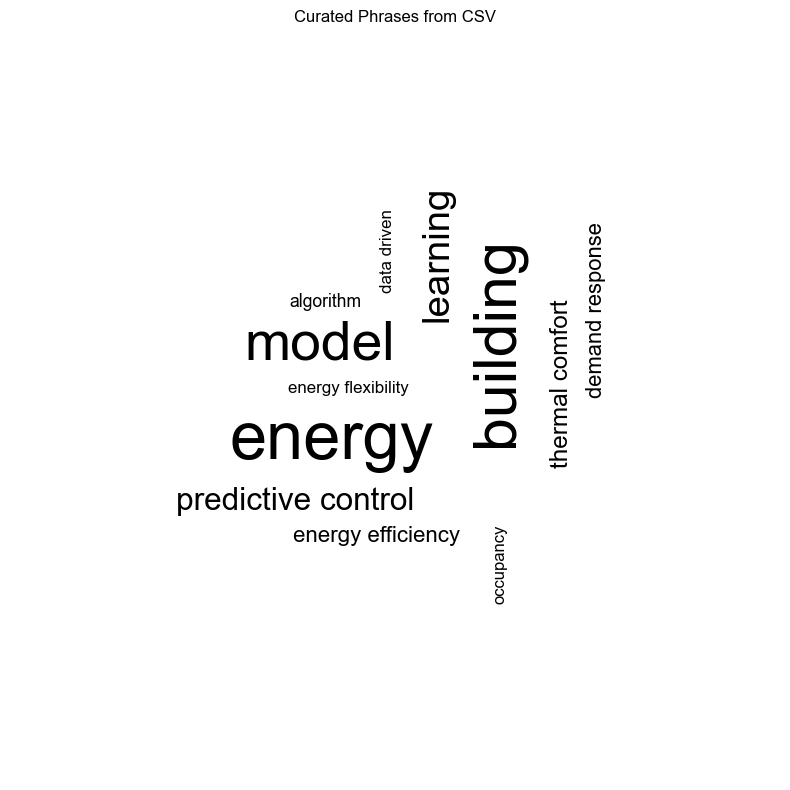

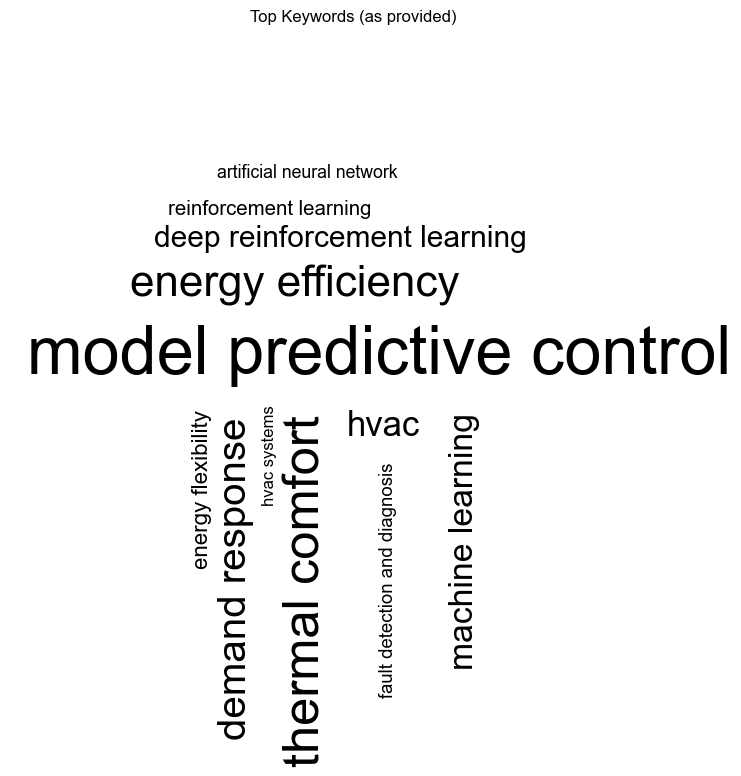

In [6]:
import os, re, random, unicodedata, json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib

matplotlib.rcParams['font.family'] = 'Arial'
random.seed(11)

# ------------ paths ------------
DOWNLOAD_DIR = 'papers_json'  # Directory containing JSON files
KEYWORDS_CSV = "csv/_keywords.csv"
TOP_N = 12  # show more terms

# ------------ helpers ------------
def normalize_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("artifitial", "artificial")
    return (s.replace("\ufb01","fi").replace("\ufb02","fl")
             .replace("–","-").replace("—","-"))

def phrase_to_regex(phrase: str):
    # Flexible match allowing hyphen/space variations & suffixes
    parts = [re.escape(t) + r"\w*" for t in re.split(r"[-\s]+", phrase.strip()) if t]
    if not parts: return None
    return re.compile(r"(?:%s)" % r"[-\s]*".join(parts), re.IGNORECASE)

def split_terms(s: str):
    """Split author-supplied keywords when they are lumped into a single field."""
    if pd.isna(s): return []
    # split on comma, semicolon, or pipe
    return [x.strip() for x in re.split(r"[;,|]", str(s)) if x.strip()]

def strip_parens(s: str):
    # remove parenthetical mentions like "(review)" or "(DSM)"
    return re.sub(r'\s*\([^)]*\)', '', s).strip()

def clean_keyword_phrase(s: str):
    """Light cleaning but keep the phrase intact."""
    s = normalize_text(s)
    s = strip_parens(s)
    # collapse internal whitespace & stray hyphen spacing
    s = re.sub(r"\s+", " ", s)
    s = s.strip()
    return s

def draw_tag(items, title):
    if not items:
        print(title + ": no phrases to display."); return

    # --- size scaling: compress range a bit to reduce crowding ---
    vals = [v for _, v in items]; vmin, vmax = min(vals), max(vals)
    fmin, fmax = 12, 48
    def scale(v): return fmin + (v - vmin) * (fmax - fmin) / (vmax - vmin) if vmax != vmin else 28

    import numpy as np
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off"); ax.set_title(title)

    MAX_ITERS = 8000
    PAD_X, PAD_Y = 1, 1
    MARG_X, MARG_Y = 0.06, 0.08
    R_BASE, R_GAIN = 0.010, 0.0007
    JITTER = 0.12
    ROTATIONS = [0, 90]

    fig.canvas.draw(); renderer = fig.canvas.get_renderer()
    placed = []

    items_sorted = sorted(items, key=lambda kv: kv[1], reverse=True)

    def try_place(txt):
        theta = 0.0; r = R_BASE
        cx, cy = 0.5, 0.5
        golden = 0.5*(3-np.sqrt(5)) * 2*np.pi
        for _ in range(MAX_ITERS):
            theta += golden
            r += R_GAIN
            x = cx + r*np.cos(theta) + np.random.uniform(-JITTER, JITTER)
            y = cy + r*np.sin(theta) + np.random.uniform(-JITTER, JITTER)
            if x < MARG_X or x > 1-MARG_X or y < MARG_Y or y > 1-MARG_Y:
                continue
            txt.set_position((x, y))
            bbox = txt.get_window_extent(renderer=renderer).expanded(PAD_X, PAD_Y)
            if not any(bbox.overlaps(b) for b in placed):
                placed.append(bbox)
                return True
        return False

    for i, (phrase, cnt) in enumerate(items_sorted):
        fs_target = scale(cnt)
        rotation = ROTATIONS[i % len(ROTATIONS)]
        for shrink in (1.0, 0.95, 0.9, 0.85, 0.8, 0.75):
            txt = ax.text(0.5, 0.5, phrase,
                          fontsize=fs_target*shrink,
                          rotation=rotation,
                          ha="center", va="center",
                          fontname="Arial")
            if try_place(txt):
                break
            txt.remove()

    plt.tight_layout(); plt.show()

# ------------ data ingest ------------
def extract_keywords_from_json(folder_path):
    """
    Extract keywords as phrases from JSON files, splitting on commas/semicolons
    when authors lump multiple keywords into a single string. Keep phrases intact.
    """
    all_keywords_raw = []   # keep an original for display if you want
    all_keywords_clean = [] # normalized for counting

    for filename in os.listdir(folder_path):
        if not filename.endswith('.json'):
            continue
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        keywords_data = (
            data.get('full-text-retrieval-response', {})
                .get('coredata', {})
                .get('dcterms:subject', [])
        )

        # Scopus-like export: each item usually has its own '$'
        for kw in keywords_data:
            if '$' not in kw:
                continue
            raw_field = kw['$']
            # split a field like "demand response; model predictive control"
            for phrase in split_terms(raw_field):
                clean = clean_keyword_phrase(phrase)
                if not clean:
                    continue
                all_keywords_raw.append(phrase)
                all_keywords_clean.append(clean.lower())  # count in lowercase

    return all_keywords_raw, all_keywords_clean

# ------------ main execution ------------
print(f"Extracting keywords from JSON files in {DOWNLOAD_DIR}...")
raw_keywords, keywords_norm = extract_keywords_from_json(DOWNLOAD_DIR)
print(f"Found {len(keywords_norm)} keyword phrases")

# Build a DataFrame (optional, for compatibility with your curated matching)
df_keywords = pd.DataFrame({
    # store the cleaned form for matching/regex; keep a raw column if you like
    'Keyword': [normalize_text(k) for k in keywords_norm],
    'Year': [2023] * len(keywords_norm)  # adjust if you have year data
})

titles = df_keywords['Keyword'].astype(str)

# ===== Plot A: Curated phrases (original terms; drop loc_post variants) =====
curated_counts = []
curated_terms_clean = []
if os.path.exists(KEYWORDS_CSV):
    kw = pd.read_csv(KEYWORDS_CSV)
    cmap = {c.lower(): c for c in kw.columns}
    cat_col, keys_col, ref_col = cmap.get("category"), cmap.get("keywords"), cmap.get("ref")
    if cat_col and keys_col:
        raw_terms = []
        for _, r in kw.iterrows():
            raw_terms += split_terms(r[keys_col])
            if ref_col and pd.notna(r[ref_col]): raw_terms += split_terms(r[ref_col])

        # remove placeholders: loc_post variants and underscores
        BAD_LOC = re.compile(r"\bloc[_\-\s]?(post|pre)\b", re.I)
        for term in raw_terms:
            t = term.strip()
            if not t: continue
            tflat = t.lower().replace("_"," ").replace("-"," ").strip()
            if "_" in t or BAD_LOC.search(t) or tflat in {"loc post","post loc"}:
                continue
            curated_terms_clean.append(t)

        # count with flexible regex (original terms as shown)
        for t in curated_terms_clean:
            rx = phrase_to_regex(t)
            if rx is None: continue
            hits = int(titles.str.contains(rx, na=False).sum())
            if hits > 0: curated_counts.append((t, hits))

curated_counts.sort(key=lambda x: x[1], reverse=True)
draw_tag(curated_counts[:TOP_N], "Curated Phrases from CSV")

# ===== Plot B: Top Keywords (as provided in JSON) =====
# Count exact phrases (case-insensitive) but display in a nice title case
counts = Counter(keywords_norm)

# Optional: unify display casing by choosing the most common raw variant per normalized key
# Build a map from normalized -> most frequent display string
display_map = {}
raw_counter = Counter([normalize_text(clean_keyword_phrase(r)).lower() for r in raw_keywords])
for norm_key in counts:
    # pick the most common raw spelling that normalizes to this norm_key
    # fall back to the norm_key itself
    candidates = [r for r in raw_counter if r == norm_key]
    if candidates:
        best = max(candidates, key=lambda c: raw_counter[c])
        display_map[norm_key] = best
    else:
        display_map[norm_key] = norm_key

top_keyword_items = [(display_map[k], v) for k, v in counts.most_common(TOP_N)]
draw_tag(top_keyword_items, "Top Keywords (as provided)")
